In [1]:
# Import Libraries

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers
from matplotlib import pyplot as plt

# Setup the output 

pd.options.display.max_rows = 8
pd.options.display.float_format = "{:.1f}".format

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load California Housing Dataset

train_df = pd.read_csv(".../california_housing_train.csv")
test_df = pd.read_csv(".../california_housing_test.csv")

In [3]:
train_df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.3,34.2,15.0,5612.0,1283.0,1015.0,472.0,1.5,66900.0
1,-114.5,34.4,19.0,7650.0,1901.0,1129.0,463.0,1.8,80100.0
2,-114.6,33.7,17.0,720.0,174.0,333.0,117.0,1.7,85700.0
3,-114.6,33.6,14.0,1501.0,337.0,515.0,226.0,3.2,73400.0
...,...,...,...,...,...,...,...,...,...
16996,-124.3,40.7,36.0,2349.0,528.0,1194.0,465.0,2.5,79000.0
16997,-124.3,41.8,17.0,2677.0,531.0,1244.0,456.0,3.0,103600.0
16998,-124.3,41.8,19.0,2672.0,552.0,1298.0,478.0,2.0,85800.0
16999,-124.3,40.5,52.0,1820.0,300.0,806.0,270.0,3.0,94600.0


In [4]:
# To shuffle the training set

train_df = train_df.reindex(np.random.permutation(train_df.index)).reset_index(drop=True)

### Preprocessing

In [5]:
# Normalization on training set

train_df_mean = train_df.mean()
train_df_std = train_df.std()
train_df_norm = (train_df-train_df_mean)/train_df_std

In [6]:
train_df_norm.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,0.6,-0.7,0.2,-0.4,-0.3,-0.6,-0.2,-0.5,1.3
1,0.8,-0.7,0.5,-0.1,-0.3,-0.1,-0.2,0.5,-0.2
2,0.5,-0.7,0.6,-0.5,-0.5,-0.5,-0.5,0.9,0.1
3,1.2,-1.3,-1.1,-0.4,-0.1,-0.0,-0.2,-0.7,-1.0
4,-1.4,2.3,-0.4,-0.2,-0.1,-0.3,-0.1,-1.2,-1.1


In [7]:
# Normalization on Test set

test_df_mean = test_df.mean()
test_df_std = test_df.std()
test_df_norm = (test_df - test_df_mean) / test_df_std

### Create Model

In [8]:
# Create a column 'Costly House' which is 1 if 'median house value' is greater than some threshold else 0

train_df_norm.median_house_value

0        1.3
1       -0.2
2        0.1
3       -1.0
        ... 
16996   -0.9
16997   -1.3
16998    1.0
16999    0.3
Name: median_house_value, Length: 17000, dtype: float64

In [9]:
# The value is between -3 to +3

train_df.quantile(q=0.75)

longitude              -118.0
latitude                 37.7
housing_median_age       37.0
total_rooms            3151.2
                       ...   
population             1721.0
households              605.2
median_income             4.8
median_house_value   265000.0
Name: 0.75, Length: 9, dtype: float64

In [10]:
# 75th percentile of median house value is 265000 which is chosen as threshold

threshold = 265000

train_df_norm['Costly_House'] = (train_df["median_house_value"] > threshold).astype(float)

In [11]:
train_df_norm

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,Costly_House
0,0.6,-0.7,0.2,-0.4,-0.3,-0.6,-0.2,-0.5,1.3,1.0
1,0.8,-0.7,0.5,-0.1,-0.3,-0.1,-0.2,0.5,-0.2,0.0
2,0.5,-0.7,0.6,-0.5,-0.5,-0.5,-0.5,0.9,0.1,0.0
3,1.2,-1.3,-1.1,-0.4,-0.1,-0.0,-0.2,-0.7,-1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
16996,1.0,-0.7,0.8,0.0,-0.1,0.1,-0.0,-0.2,-0.9,0.0
16997,-0.1,0.5,1.9,-0.1,-0.1,-0.1,-0.1,-0.9,-1.3,0.0
16998,0.9,-0.9,-1.0,-0.3,-0.5,-0.5,-0.5,1.6,1.0,1.0
16999,0.4,-0.6,-0.9,1.8,1.3,1.5,1.5,0.6,0.3,0.0


In [12]:
test_df_norm['Costly_House'] = (test_df["median_house_value"] > threshold).astype(float)

In [13]:
# Input Layer

inputs = {
    'median_income' : keras.Input(shape=(1,)),
    'total_rooms' : keras.Input(shape=(1,))
}

In [14]:
def create_model(my_inputs, my_learning_rate, METRICS):
    concatenated_inputs = tf.keras.layers.Concatenate()(my_inputs.values())
    dense = layers.Dense(units=1, input_shape=(1,),name='dense_layer', activation=tf.sigmoid)
    dense_output = dense(concatenated_inputs)
    
    my_outputs = {
    'dense': dense_output,
    }
    model = tf.keras.Model(inputs=my_inputs, outputs=my_outputs)

    
    model.compile(optimizer=tf.keras.optimizers.experimental.RMSprop(learning_rate=my_learning_rate),                                                   
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=METRICS)
    return model  

In [15]:
def train_model(model, dataset, epochs, label_name,batch_size=None, shuffle=True):
    
    features = {name:np.array(value) for name, value in dataset.items()}
    label = np.array(features.pop(label_name)) 
    history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle)
    epochs = history.epoch

  
    hist = pd.DataFrame(history.history)

    return epochs, hist  
    

In [16]:
def plot_curve(epochs, hist, list_of_metrics):
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Value")

    for m in list_of_metrics:
        x = hist[m]
        plt.plot(epochs[1:], x[1:], label=m)

    plt.legend()

Epoch 1/20
170/170 [==============================] - 2s 5ms/step - loss: 0.6161 - accuracy: 0.7342 - precision: 0.4770 - recall: 0.6616
Epoch 2/20
170/170 [==============================] - 1s 4ms/step - loss: 0.5595 - accuracy: 0.7614 - precision: 0.5183 - recall: 0.6355
Epoch 3/20
170/170 [==============================] - 0s 3ms/step - loss: 0.5129 - accuracy: 0.7814 - precision: 0.5570 - recall: 0.6096
Epoch 4/20
170/170 [==============================] - 0s 3ms/step - loss: 0.4748 - accuracy: 0.7975 - precision: 0.5969 - recall: 0.5837
Epoch 5/20
170/170 [==============================] - 1s 4ms/step - loss: 0.4455 - accuracy: 0.8117 - precision: 0.6410 - recall: 0.5599
Epoch 6/20
170/170 [==============================] - 1s 4ms/step - loss: 0.4250 - accuracy: 0.8216 - precision: 0.6824 - recall: 0.5347
Epoch 7/20
170/170 [==============================] - 1s 5ms/step - loss: 0.4112 - accuracy: 0.8270 - precision: 0.7168 - recall: 0.5084
Epoch 8/20
170/170 [=====================

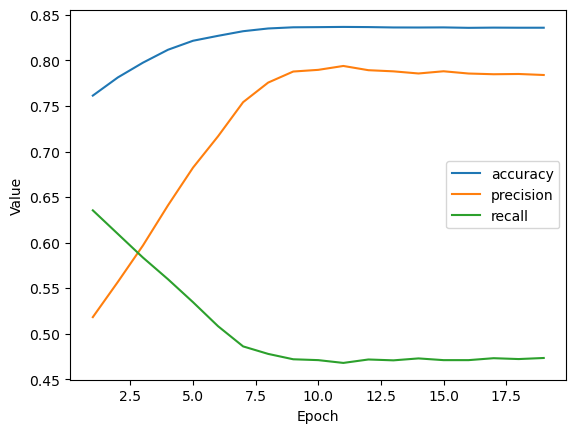

In [17]:
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 100
classification_threshold = 0.52
label_name = "Costly_House"

# Here is the updated definition of METRICS:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                      threshold=classification_threshold),
      tf.keras.metrics.Precision(thresholds=classification_threshold,
                                 name='precision' 
                                 ),
      tf.keras.metrics.Recall(thresholds=classification_threshold,
                              name="recall"),
]

# Establish the model's topography.
my_model = create_model(inputs, learning_rate, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs, 
                           label_name, batch_size)

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['accuracy', "precision", "recall"] 
plot_curve(epochs, hist, list_of_metrics_to_plot)



In [18]:
features = {name:np.array(value) for name, value in test_df_norm.items()}
label = np.array(features.pop(label_name))

my_model.evaluate(x = features, y = label, batch_size=batch_size)

30/30 [==============================] - 1s 3ms/step - loss: 0.4069 - accuracy: 0.8310 - precision: 0.7685 - recall: 0.4584


[0.40687641501426697,
 0.8309999704360962,
 0.768539309501648,
 0.4584450423717499]

Epoch 1/20
170/170 [==============================] - 2s 5ms/step - loss: 0.7347 - auc: 0.5321
Epoch 2/20
170/170 [==============================] - 1s 4ms/step - loss: 0.6382 - auc: 0.6434
Epoch 3/20
170/170 [==============================] - 1s 5ms/step - loss: 0.5605 - auc: 0.7307
Epoch 4/20
170/170 [==============================] - 1s 5ms/step - loss: 0.5021 - auc: 0.7863
Epoch 5/20
170/170 [==============================] - 1s 5ms/step - loss: 0.4602 - auc: 0.8178
Epoch 6/20
170/170 [==============================] - 1s 4ms/step - loss: 0.4324 - auc: 0.8325
Epoch 7/20
170/170 [==============================] - 0s 3ms/step - loss: 0.4157 - auc: 0.8363
Epoch 8/20
170/170 [==============================] - 1s 4ms/step - loss: 0.4066 - auc: 0.8370
Epoch 9/20
170/170 [==============================] - 1s 5ms/step - loss: 0.4018 - auc: 0.8367
Epoch 10/20
170/170 [==============================] - 1s 5ms/step - loss: 0.3993 - auc: 0.8365
Epoch 11/20
170/170 [============================

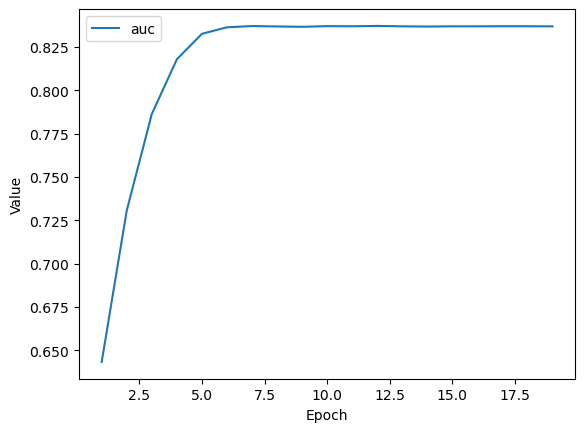

In [19]:
# Summarize model performance
learning_rate = 0.001
epochs = 20
batch_size = 100
label_name = "Costly_House"

# AUC is a reasonable "summary" metric for classification models.
METRICS = [
      tf.keras.metrics.AUC(num_thresholds=100, name='auc'),
]

my_model = create_model(inputs, learning_rate, METRICS)

epochs, hist = train_model(my_model, train_df_norm, epochs, 
                           label_name, batch_size)

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['auc'] 
plot_curve(epochs, hist, list_of_metrics_to_plot)